### Figure 1 Randomized SVD: Structured vs. Gaussian.
$$
\frac{\Vert \mathbf{A}-\hat{\mathbf{A}}_{\rm Structured}\Vert_{\rm F}}{\Vert \mathbf{A}-\hat{\mathbf{A}}_{\rm Gaussian}\Vert_{\rm F}}
$$
for matrix approximations with rank \(k=200\), computed via RSVD. Each panel superimposes histograms from three trials.

The testbed consists of all \(2,314\) matrices from the \texttt{SuiteSparse} collection  whose dimensions fall between \(300\) and \(500,000\). From left to right, we consider the SparseStack test matrix, the SparseRTT test matrix, and the complex spherical Khatri--Rao test matrix with tensor order $\ell=\lceil\log_2 n\rceil$.

The worst-case error ratio never exceeds 4, and structured test matrices sometimes beat Gaussians! These experiments suggest that structured sketching algorithms reliably produce approximation errors within a small constant factor of their Gaussian counterparts.

---

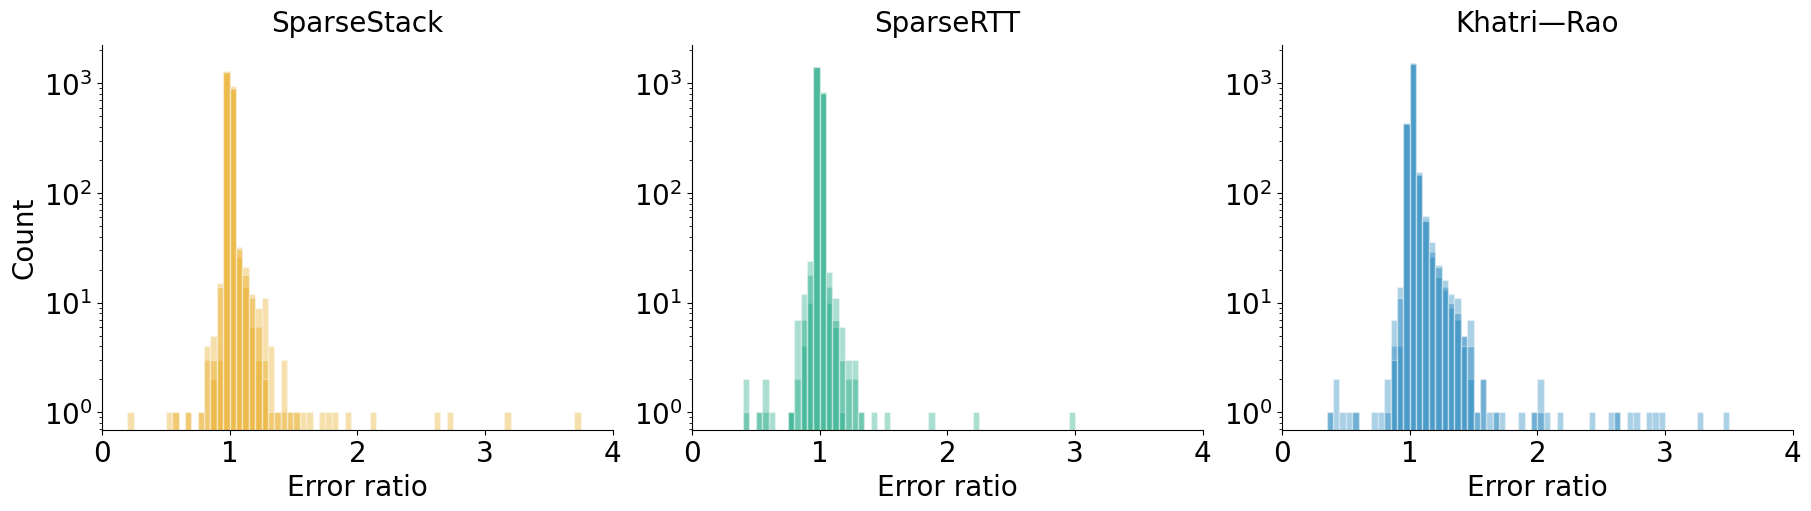

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy.io as sio

# === Unified color palette ===
colors = {
    "SparseStack": "#E69F00",   # orange
    "SparseRTT":   "#009E73",   # green
    "Khatri—Rao":  "#0072B2",   # blue (em-dash)
}

def load_ratios_per_run(matfile, method_key):
    """
    From suite_sparse_benchmarks_runs.mat, compute per-run ratios:
        relErr(method) / relErr(Gauss).
    Returns a list of 1D arrays (one per run/trial).
    """
    data = sio.loadmat(matfile, struct_as_record=False, squeeze_me=True)
    results = data["results"]

    runs = []
    for trial in results:
        g_rel = np.array(trial.Gauss.relErr, dtype=float).flatten()
        m_rel = np.array(getattr(trial, method_key).relErr, dtype=float).flatten()

        if g_rel.size and m_rel.size:
            ratio = m_rel / (g_rel + 1e-16)
            ratio = ratio[np.isfinite(ratio) & (ratio > 0)]
            if ratio.size > 0:
                runs.append(ratio)
    return runs

def plot_error_comparison(matfile, num_bins=80):
    method_info = [
        ("SparseStack",   "SparseSignIsubcols"),
        ("SparseRTT",     "SRRT"),
        ("Khatri—Rao",    "KRcomplexsphere"),
    ]

    xmin, xmax = 0.0, 4.0
    bins = np.linspace(xmin, xmax, num_bins + 1)

    plt.style.use('default')
    fig, axes = plt.subplots(1, 3, figsize=(18, 5),
                             sharey=True, constrained_layout=True)

    for ax, (method_name, method_key) in zip(axes, method_info):
        all_runs = load_ratios_per_run(matfile, method_key)

        alpha = 1.0 / len(all_runs) if len(all_runs) > 0 else 0.25
        for run_vals in all_runs:
            ax.hist(run_vals, bins=bins, edgecolor='white',
                    color=colors[method_name], alpha=alpha)

        ax.set_yscale('log')
        ax.set_xlim(xmin, xmax)
        ax.set_xticks(np.arange(xmin, xmax + 1, 1))
        ax.set_title(method_name, fontsize=20, pad=10)
        ax.set_xlabel("Error ratio", fontsize=20)
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.tick_params(labelsize=20)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)
        ax.set_facecolor('white')

    for ax in axes:
        ax.tick_params(axis='y', which='both', labelleft=True, left=True)
    axes[0].set_ylabel('Count', fontsize=20)

    plt.savefig("fig1.png", dpi=300, bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    MATFILE = "data/suite_sparse_benchmarks_runs.mat"
    plot_error_comparison(MATFILE, num_bins=80)